dataset : https://www.tensorflow.org/datasets/catalog/horses_or_humans <br>

This is a dataset concerned with differentiating horses from humans, containing images of both fictional and real versions of both the entities being classified.

In [ ]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import sys
import time

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np
trainX, trainY = tfds.as_numpy(tfds.load(
    'horses_or_humans', split = 'train', batch_size = -1, as_supervised = True))

testX, testY = tfds.as_numpy(tfds.load(
    'horses_or_humans', split = 'test', batch_size = -1, as_supervised = True))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteWVILX9/horses_or_humans-train.tfrecord*..…

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteWVILX9/horses_or_humans-test.tfrecord*...…

Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


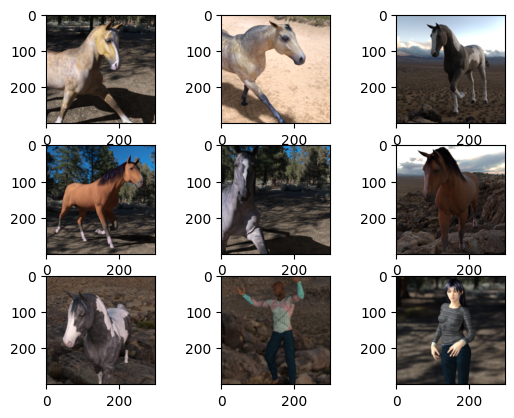

In [ ]:
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [ ]:
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

Train: X=(1027, 300, 300, 3), y=(1027,)
Test: X=(256, 300, 300, 3), y=(256,)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


> 51.456
> 47.087
> 49.756
> 46.341
> 48.780


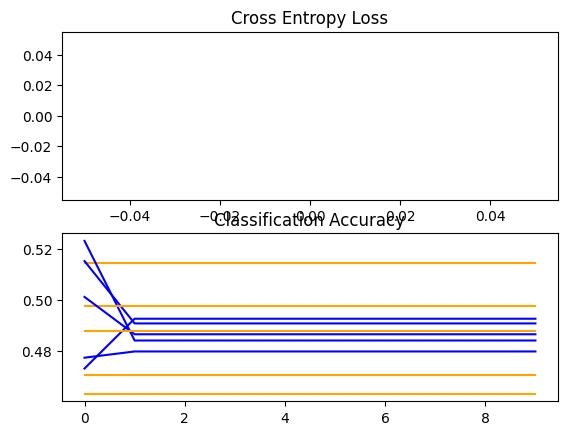

Accuracy: mean=48.684 std=1.837, n=5


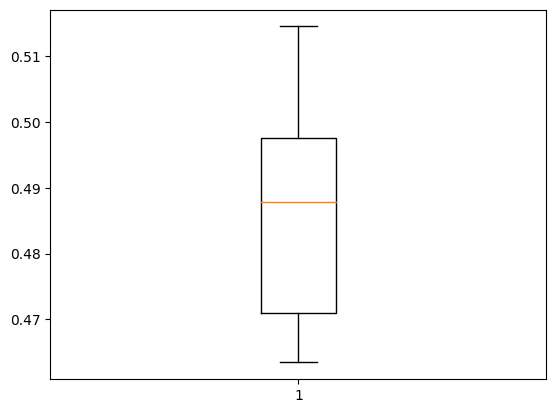

Total time taken: 2.570392413934072 minutes


In [ ]:
import time
start_time = time.time()

# load train and test dataset
def load_dataset(trainX, testX, trainY, testY):
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 300, 300, 3))
	testX = testX.reshape((testX.shape[0], 300, 300, 3))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(300, 300, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

# run the test harness for evaluating a model
def run_test_harness(trainX, trainY, testX, testY):
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

# entry point, run the test harness
run_test_harness(trainX, trainY, testX, testY)

end_time = time.time()

total_time = end_time - start_time
print("Total time taken:", total_time/60, "minutes")

In [ ]:
def run_test_harness(trainX, testX, trainY):
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# fit model
	model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
	# save model
	model.save('/content/drive/MyDrive/ColabNotebooks/DATA/Models/assignment9-1_horse_finalModel.h5')

# entry point, run the test harness
run_test_harness(trainX, testX, trainY)
end_time = time.time()

total_time = end_time - start_time
print("Total time taken:", total_time/60, "minutes")

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Total time taken: 6.27298454840978 minutes


In [ ]:
from tensorflow.keras.models import load_model
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

def run_test_harness(trainX, testX, testY):
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# load model
	model = load_model('/content/drive/MyDrive/ColabNotebooks/DATA/Models/assignment9-1_horse_finalModel.h5')
  # evaluate model on test dataset
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))

run_test_harness(trainX, testX, testY)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


> 50.000


<h2><b> == AUGMENTATION ==

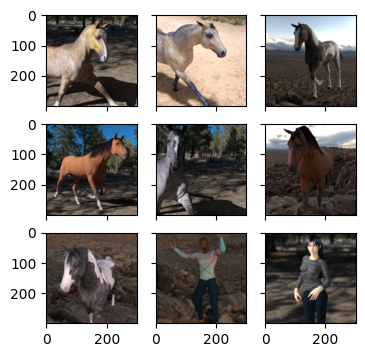

In [ ]:
# create a grid of 3x3 images
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(trainX[i*3+j], cmap=plt.get_cmap("gray"))
# show the plot
plt.show()

<h2> <b> == FEATURE STANDARDIZATION ==

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

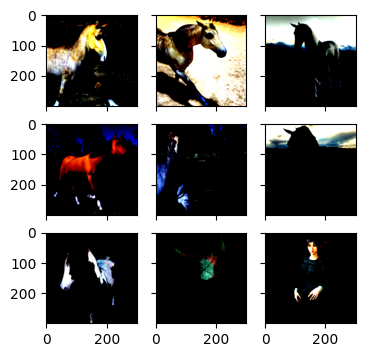

-2.2889526 -0.7172852 2.3985662


In [ ]:
# reshape to be [samples][width][height][channels]
X_train = trainX.reshape((trainX.shape[0], 300, 300, 3))
X_test = testX.reshape((testX.shape[0], 300, 300, 3))
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit parameters from data
datagen.mean = X_train.mean(axis=0)
datagen.std = X_train.std(axis=0)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, trainY, batch_size=9, shuffle=False):
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j], cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    print(X_batch.min(), X_batch.mean(), X_batch.max())
    break

<h2> <b> == ZCA WHITENING ==

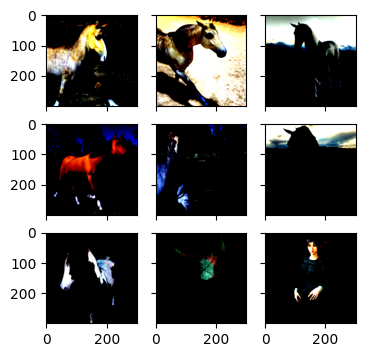

-2.2889526 -0.7172852 2.3985662


In [ ]:
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, zca_whitening=True)
# fit parameters from data
X_mean = X_train.mean(axis=0)
datagen.fit(X_train - X_mean)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train - X_mean, trainY, batch_size=9, shuffle=False):
    print(X_batch.min(), X_batch.mean(), X_batch.max())
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j], cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

<h2><b> == RANDOM SHIFTS ==

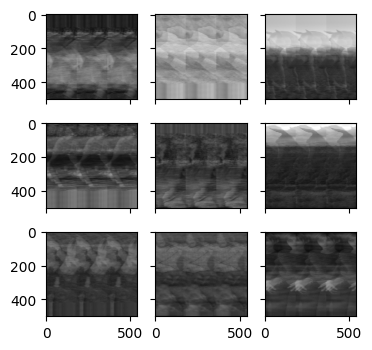

In [ ]:
# define data preparation
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(trainX, trainY, batch_size=9, shuffle=False):
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(500,540), cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

<h2><b> == SAVE AUGMENTED IMAGE DATA TO DISK ==

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


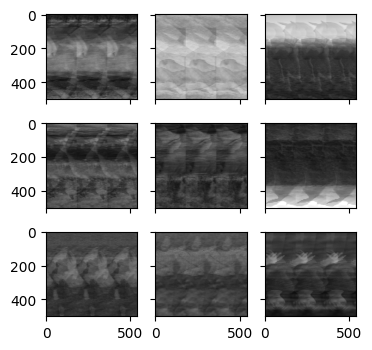

In [ ]:
# define data preparation
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(trainX, trainY, batch_size=9, shuffle=False,
                                     save_to_dir='/content/drive/MyDrive/Colab Notebooks/DATA/images', save_prefix='aug', save_format='png'):
    # create a grid of 3x3 images
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(500,540), cmap=plt.get_cmap("gray"))
    # show the plot
    plt.show()
    break

<h2> <b> == FINALIZED MODEL [WITH ADDED LAYERS] ==

In [ ]:
def load_dataset(trainX, testX, trainY, testY):
	trainX = trainX.reshape((trainX.shape[0], 540, 500, 1))
	testX = testX.reshape((testX.shape[0], 540, 500, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(540,500,1)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.2))
	model.add(Dense(2, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	plt.savefig(filename + '_plot.png')
	plt.close()

# run the test harness for evaluating a model
def run_test_harness(trainX, testX, trainY, testY):
	# load dataset
	trainX, trainY, testX, testY = load_dataset(trainX, testX, trainY, testY)
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# fit model
	history = model.fit(trainX, trainY, epochs=10, batch_size=9, validation_data=(testX, testY), verbose=0)
	# evaluate model
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 	# save model
	model.save('/content/drive/MyDrive/Colab Notebooks/DATA/Models/final_model.h5')

# entry point, run the test harness
run_test_harness(trainX, testX, trainY, testY)
start_time = time.time()
end_time = time.time()

total_time = end_time - start_time
print("Total time taken:", total_time/60, "minutes")

<h2> <b> == CONCLUSION ==

  - After performing this activity, I have learned about CNNs, or Convolutional Neural Networks, and how they work, or at least the basics of it. We got to implement some familiar steps in the middle of the activity when making a model responsible for image classification. I feel like the most important step here is the very first one, which is to augment the data, which allows the models to learn more features about the images present in the dataset. Feature standardization is basically a preprocessing step for the features, to be stable in the learning process of the model. Same concept goes to ZCA whitening, which is another preprocessing to highlight the features better for our model to pick up. Random rotations, shifts, and flips, are necessary for our model in order to be prepared to identify objects or anything it's supposed to identify in any orientation, as we can never expect something to appear at the perfect orientation all the time. Overall, making sure that you have the parameters set correctly is more important in this activity, as crashing and extremely long execution times are extremely common and hard to deal with especially with limited time.